In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tools_cvf
plt.style.use(tools_cvf.get_stylesheets(dark=True))

import weis.tools.viz_toolbox as viz_toolbox

In [2]:
%cd ~/codes/WEIS/examples/17_IEA22_Optimization

/Users/cfrontin/codes/WEIS/examples/17_IEA22_Optimization


In [3]:
# output dirs based on template for ex. 17
dir_template = "32_DesignRound1_%s"
dir_COBYLA = dir_template % "COBYLA"
dir_SLSQP = dir_template % "SLSQP"
dir_NSGA2 = dir_template % "NSGA2"
dir_DE = dir_template % "DE"

# OM log db files
fn_log_COBYLA = os.path.join(dir_COBYLA, "log_opt.sql")
fn_log_SLSQP = os.path.join(dir_SLSQP, "log_opt.sql")
fn_log_NSGA2 = os.path.join(dir_NSGA2, "log_opt.sql")
fn_log_DE = os.path.join(dir_DE, "log_opt.sql_%s")

# WEIS stashes design/constraint/objective var files located here
fn_vars_COBYLA = os.path.join(dir_COBYLA, "problem_vars.json")
fn_vars_SLSQP = os.path.join(dir_SLSQP, "problem_vars.json")
fn_vars_NSGA2 = os.path.join(dir_NSGA2, "problem_vars.json")
fn_vars_DE = os.path.join(dir_DE, "problem_vars.json")

In [4]:
# ... load them
vars_COBYLA = viz_toolbox.load_vars_file(fn_vars_COBYLA)
vars_SLSQP = viz_toolbox.load_vars_file(fn_vars_SLSQP)
# this call verifies, (optionally) unifies, and corrects the var files
vars_unified = viz_toolbox.verify_vars(vars_COBYLA, vars_SLSQP)

# vars_NSGA2 = viz_toolbox.load_vars_file(fn_vars_NSGA2)
# vars_unified = viz_toolbox.verify_vars(vars_COBYLA, vars_SLSQP, vars_NSGA2)
# vars_DE = viz_toolbox.load_vars_file(fn_vars_DE)
# vars_unified = viz_toolbox.verify_vars(vars_COBYLA, vars_SLSQP, vars_DE)

In [5]:
# load the data from the OM DB
dataOM_COBYLA = viz_toolbox.load_OMsql(fn_log_COBYLA)
dataOM_SLSQP = viz_toolbox.load_OMsql(fn_log_SLSQP)
dataOM_NSGA2 = viz_toolbox.load_OMsql(fn_log_NSGA2)
dataOM_DE = viz_toolbox.load_OMsql_multi(
  fn_log_DE % "*",
  meta=fn_log_DE % "meta",
)

# describe the keys that have been found
print()
keys_all, _, _ = viz_toolbox.compare_om_data(
  dataOM_COBYLA,
  dataOM_SLSQP,
  "COBYLA", "SLSQP",
  verbose=True,
)
print()

# grab the keys that we have in the unified vars
keys_obj = [v["name"] for k, v in vars_unified["objectives"].items()]
keys_DV = [v["name"] for k, v in vars_unified["design_vars"].items()]
keys_constr = {v["name"]: [v["lower"], v["upper"]] for k, v in vars_unified["constraints"].items()}

# pretty print the case we're looking at
viz_toolbox.prettyprint_variables(keys_all, keys_obj, keys_DV, keys_constr)


the following keys are in both COBYLA and SLSQP:
	floating.memgrp1.outer_diameter_in
	raft.heave_period
	rank
	floatingse.constr_draft_heel_margin
	raft.pitch_period
	floatingse.constr_fixed_margin
	floating.jointdv_0
	floatingse.constr_freeboard_heel_margin
	iter
	floatingse.constr_fairlead_wave
	floatingse.constr_variable_margin
	floating.jointdv_1
	floatingse.metacentric_height
	floatingse.system_structural_mass
	raft.Max_PtfmPitch


-- floating.memgrp1.outer_diameter_in
<> raft.heave_period
?? rank
<> floatingse.constr_draft_heel_margin
<> raft.pitch_period
<> floatingse.constr_fixed_margin
-- floating.jointdv_0
<> floatingse.constr_freeboard_heel_margin
?? iter
<> floatingse.constr_fairlead_wave
<> floatingse.constr_variable_margin
-- floating.jointdv_1
<> floatingse.metacentric_height
** floatingse.system_structural_mass
<> raft.Max_PtfmPitch



In [6]:
# extract and install feasibility evaluations
feas, vfeas = viz_toolbox.get_feasible_iterations(dataOM_DE, vars_unified, feas_tol=1e-5)
dataOM_DE["feas_total"] = feas
for k, v in vfeas.items():
  dataOM_DE[f"feas_{k}"] = v

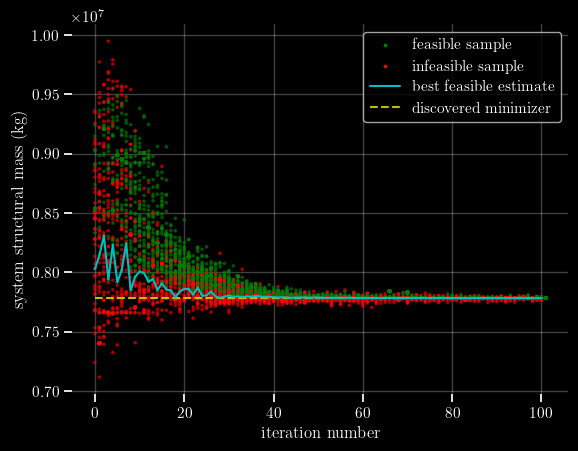

In [7]:
# plot DE results

fig, ax = plt.subplots()
ax.scatter([], [], s=3.0, c="g", label="feasible sample")
ax.scatter([], [], s=3.0, c="r", label="infeasible sample")
ax.scatter(
  dataOM_DE["iter"],
  dataOM_DE["floatingse.system_structural_mass"],
  s=3.0,
  c=["g" if d else "r" for d in dataOM_DE["feas_total"]],
  alpha=0.5,
  label="_simulation iterations_",
)
ax.plot(
  range(np.max(dataOM_DE["iter"])),
  [
    np.min(np.array(dataOM_DE["floatingse.system_structural_mass"])[
      dataOM_DE["feas_total"].flatten() & (np.array(dataOM_DE["iter"]) == iter).flatten()
    ]) for iter in range(np.max(dataOM_DE["iter"]))
  ],
  c="c",
  zorder=1000,
  label="best feasible estimate",
)
ax.plot(
  range(np.max(dataOM_DE["iter"])),
  np.min(
    np.array(dataOM_DE["floatingse.system_structural_mass"])[dataOM_DE["feas_total"].flatten()]
  )*np.ones_like(range(np.max(dataOM_DE["iter"]))),
  "--y",
  zorder=500,
  label="discovered minimizer",
)
ax.grid(which="major", alpha=0.25)
ax.set_xlabel("iteration number")
ax.set_ylabel("system structural mass (kg)")
ax.legend()

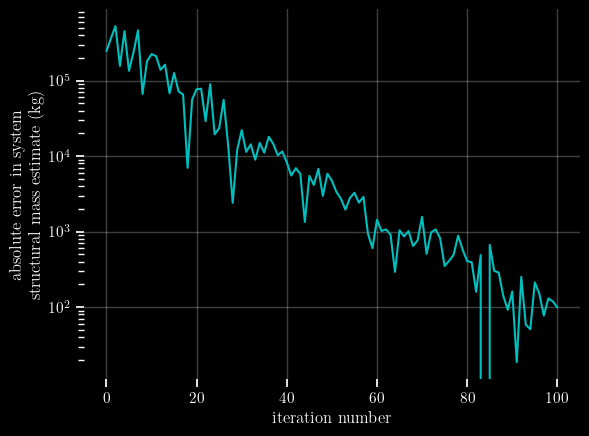

In [8]:
# plot DE optimization convergence results

fig, ax = plt.subplots()
ax.semilogy(
  range(np.max(dataOM_DE["iter"])),
  np.abs([np.min(np.array(dataOM_DE["floatingse.system_structural_mass"])[
    dataOM_DE["feas_total"].flatten() & (np.array(dataOM_DE["iter"]) == iter).flatten()
  ]) for iter in range(np.max(dataOM_DE["iter"])) ]
  - np.min(
    np.array(
      dataOM_DE["floatingse.system_structural_mass"]
    )[dataOM_DE["feas_total"].flatten()]
  )*np.ones_like(range(np.max(dataOM_DE["iter"])))),
  c="c",
  label="error in iteration-wise best feasible estimate",
)
ax.grid(which="major", alpha=0.25)
ax.set_xlabel("iteration number")
ax.set_ylabel("absolute error in system \n structural mass estimate (kg)")
pass

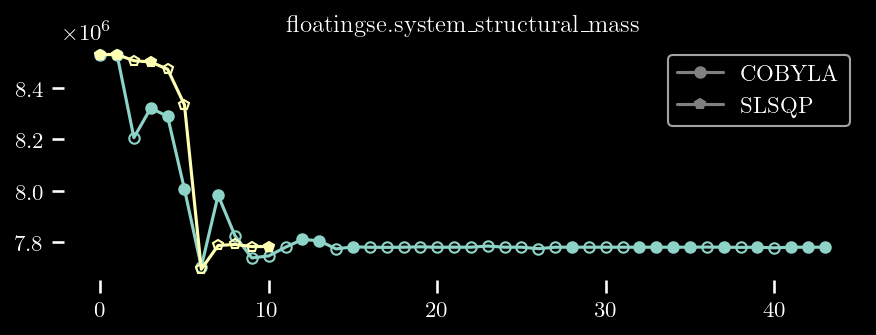

In [9]:
viz_toolbox.plot_conv(
  keys_obj,
  {
    "COBYLA": (dataOM_COBYLA, vars_COBYLA),
    "SLSQP": (dataOM_SLSQP, vars_SLSQP),
    # "NSGA2": (dataOM_NSGA2, vars_SLSQP),
    # "DE": (dataOM_DE, vars_SLSQP),
  },
  feas_tol=1e-5,
) ;

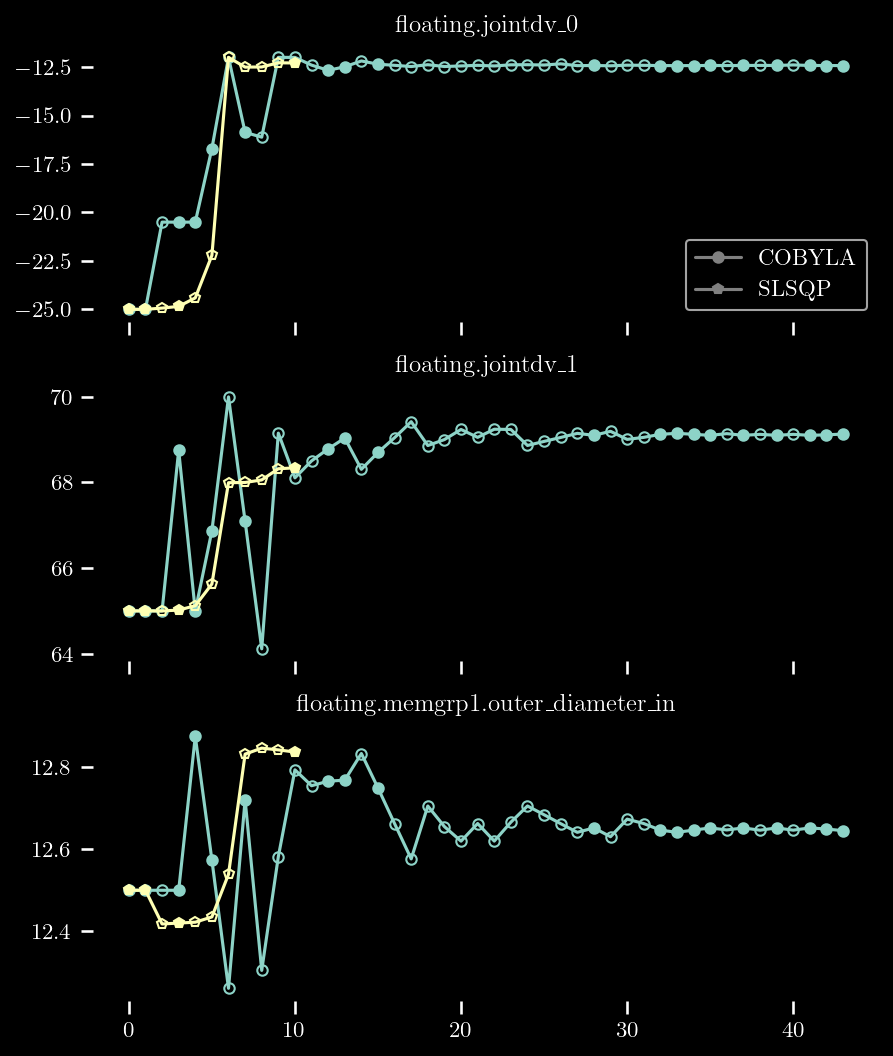

In [10]:
viz_toolbox.plot_conv(
  keys_DV,
  {
    "COBYLA": (dataOM_COBYLA, vars_COBYLA),
    "SLSQP": (dataOM_SLSQP, vars_SLSQP),
    # "NSGA2": (dataOM_NSGA2, vars_SLSQP),
    # "DE": (dataOM_DE, vars_SLSQP),
  },
  feas_tol=1e-5,
  # use_casewise_feasibility=True,
) ;

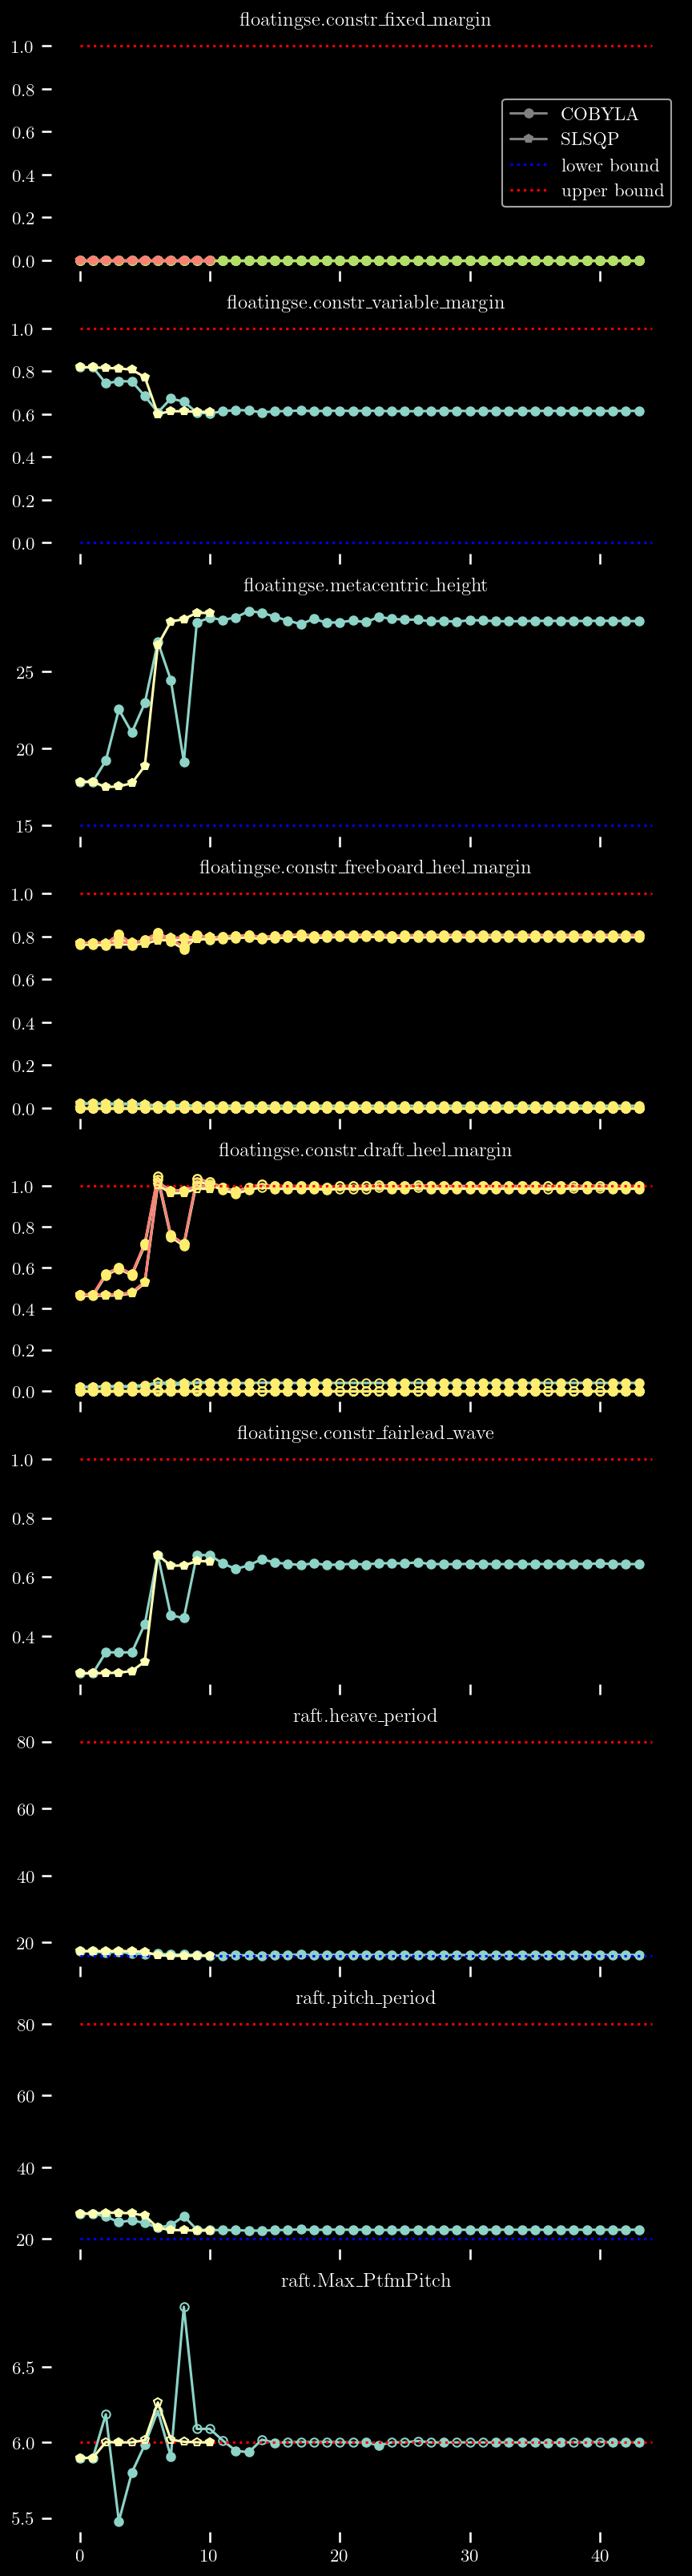

In [11]:
viz_toolbox.plot_conv(
  keys_constr,
  {
    "COBYLA": (dataOM_COBYLA, vars_COBYLA),
    "SLSQP": (dataOM_SLSQP, vars_SLSQP),
    # "NSGA2": (dataOM_NSGA2, vars_SLSQP),
    # "DE": (dataOM_DE, vars_SLSQP),
  },
  feas_tol=1e-5,
  use_casewise_feasibility=True,
) ;